In [4]:
#!conda install -c conda-forge seaborn -y

In [5]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

##Import any other packages you may need here

## Read the Data 

In [106]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
filepath='../dataset/'
all_xray_df = pd.read_csv('../dataset/Data_Entry_2017.csv')
print(all_xray_df.shape)
all_xray_df.sample(5)

(112120, 12)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
21442,00005716_001.png,No Finding,1,5716,49,F,PA,3056,2544,0.139000,0.139000,NaN
79484,00019527_001.png,Consolidation|Mass,1,19527,67,M,AP,2500,2048,0.168000,0.168000,NaN
99716,00026412_029.png,No Finding,29,26412,26,M,PA,2021,2021,0.194311,0.194311,NaN
96737,00025498_004.png,Infiltration,4,25498,86,M,PA,3056,2544,0.139000,0.139000,NaN
56240,00014015_016.png,Edema|Effusion|Infiltration|Pneumonia,16,14015,31,F,PA,2992,2991,0.143000,0.143000,NaN


In [107]:
data_sample = pd.read_csv('sample_labels.csv')
print(data_sample.shape)
data_sample.sample(5)

(5606, 11)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
543,00002798_001.png,No Finding,1,2798,069Y,M,AP,2500,2048,0.171,0.171
1451,00007526_029.png,No Finding,29,7526,066Y,M,AP,2500,2048,0.168,0.168
5043,00026810_011.png,Infiltration,11,26810,055Y,M,AP,3056,2544,0.139,0.139
1874,00009876_000.png,No Finding,0,9876,066Y,M,PA,2992,2991,0.143,0.143
3715,00018245_005.png,No Finding,5,18245,044Y,F,PA,2658,2641,0.143,0.143


In [108]:
bbox_list_df = pd.read_csv('../dataset/BBox_List_2017.csv')
print(bbox_list_df.shape)
bbox_list_df.head()

(984, 9)


,Image Index,Finding Label,Bbox [x,y,w,h],Unnamed: 6,Unnamed: 7,Unnamed: 8
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441,NaN,NaN,NaN
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525,NaN,NaN,NaN
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153,NaN,NaN,NaN
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034,NaN,NaN,NaN
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695,NaN,NaN,NaN


EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Also, **describe your findings and how will you set up the model training based on the findings.**

## EDA

In [109]:
## EDA
# Todo 
all_xray_df.columns, data_sample.columns

(Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
        'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
        'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Unnamed: 11'],
       dtype='object'),
 Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
        'Patient Age', 'Patient Gender', 'View Position', 'OriginalImageWidth',
        'OriginalImageHeight', 'OriginalImagePixelSpacing_x',
        'OriginalImagePixelSpacing_y'],
       dtype='object'))

In [110]:
all_xray_df=all_xray_df.rename({'OriginalImage[Width':'OriginalImageWidth',
                    'Height]':'OriginalImageHeight',
                    'OriginalImagePixelSpacing[x':'OriginalImagePixelSpacing_x',
                   'y]':'OriginalImagePixelSpacing_y'},axis=1)
all_xray_df.columns=all_xray_df.columns.str.replace(' ', '')
data_sample.columns=data_sample.columns.str.replace(' ', '')
all_xray_df.columns

Index(['ImageIndex', 'FindingLabels', 'Follow-up#', 'PatientID', 'PatientAge',
       'PatientGender', 'ViewPosition', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacing_x',
       'OriginalImagePixelSpacing_y', 'Unnamed:11'],
      dtype='object')

In [111]:
data_sample['FindingLabels'].value_counts()

FindingLabels
No Finding                                                3044
Infiltration                                               503
Effusion                                                   203
Atelectasis                                                192
Nodule                                                     144
                                                          ... 
Atelectasis|Edema|Effusion|Infiltration|Pneumonia            1
Atelectasis|Consolidation|Edema|Infiltration|Pneumonia       1
Atelectasis|Effusion|Hernia                                  1
Atelectasis|Hernia|Pneumothorax                              1
Cardiomegaly|Effusion|Emphysema                              1
Name: count, Length: 244, dtype: int64

In [112]:
data_sample['FindingLabels'].nunique()

244

In [113]:
all_xray_df.describe()

,Follow-up#,PatientID,PatientAge,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,Unnamed:11
count,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,112120.000000,0.0
mean,8.573751,14346.381743,46.901463,2646.078844,2486.438842,0.155649,0.155649,NaN
std,15.406320,8403.876972,16.839923,341.246429,401.268227,0.016174,0.016174,NaN
min,0.000000,1.000000,1.000000,1143.000000,966.000000,0.115000,0.115000,NaN
25%,0.000000,7310.750000,35.000000,2500.000000,2048.000000,0.143000,0.143000,NaN
50%,3.000000,13993.000000,49.000000,2518.000000,2544.000000,0.143000,0.143000,NaN
75%,10.000000,20673.000000,59.000000,2992.000000,2991.000000,0.168000,0.168000,NaN
max,183.000000,30805.000000,414.000000,3827.000000,4715.000000,0.198800,0.198800,NaN


In [114]:
all_xray_df.isna().sum()

ImageIndex                          0
FindingLabels                       0
Follow-up#                          0
PatientID                           0
PatientAge                          0
PatientGender                       0
ViewPosition                        0
OriginalImageWidth                  0
OriginalImageHeight                 0
OriginalImagePixelSpacing_x         0
OriginalImagePixelSpacing_y         0
Unnamed:11                     112120
dtype: int64

### FindingLabels

In [115]:
all_xray_df['FindingLabels'].nunique()

836

In [116]:
all_xray_df['FindingLabels'].value_counts(normalize=True)
#sns.countplot(all_xray_df['FindingLabels'])

FindingLabels
No Finding                                                         0.538361
Infiltration                                                       0.085150
Atelectasis                                                        0.037594
Effusion                                                           0.035275
Nodule                                                             0.024126
                                                                     ...   
Atelectasis|Consolidation|Edema|Effusion|Infiltration|Pneumonia    0.000009
Atelectasis|Consolidation|Effusion|Emphysema|Mass|Pneumothorax     0.000009
Cardiomegaly|Effusion|Pleural_Thickening|Pneumothorax              0.000009
Edema|Infiltration|Pneumothorax                                    0.000009
Atelectasis|Consolidation|Mass|Pleural_Thickening|Pneumothorax     0.000009
Name: proportion, Length: 836, dtype: float64

In [117]:
unique_labels=set()
for label in all_xray_df['FindingLabels'].unique().tolist():
    labels=label.split('|')
    for l in labels:
        unique_labels.add(l)
unique_labels


{'Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'No Finding',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax'}

In [118]:
unique_labels.remove('No Finding')
unique_labels

{'Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax'}

<Axes: >

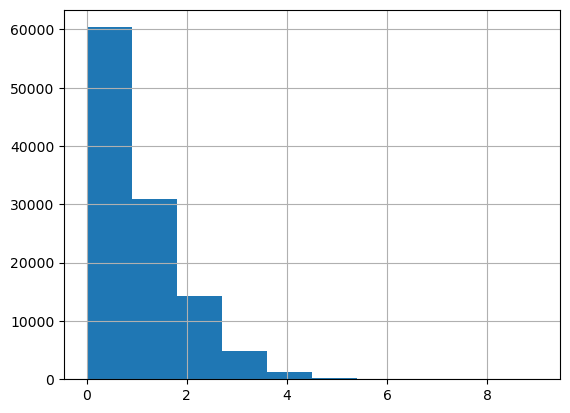

In [119]:
def f_disease_count(label):
    disease_count=0
    if label!='No Finding':
        disease_count= len(label.split('|'))
    return disease_count
    
all_xray_df['disease_count'] = all_xray_df.apply(lambda x: f_disease_count(x.FindingLabels), axis=1)
all_xray_df['disease_count'].hist()

In [120]:
all_xray_df['disease_count'].value_counts(normalize=True)*100

disease_count
0    53.836068
1    27.615947
2    12.759543
3     4.331074
4     1.112201
5     0.268462
6     0.059757
7     0.014270
9     0.001784
8     0.000892
Name: proportion, dtype: float64

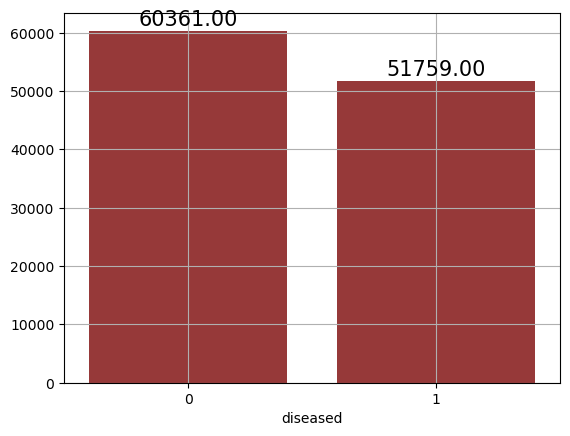

In [309]:
all_xray_df['diseased']=all_xray_df['disease_count'].apply(lambda x: 1 if x>0 else 0)

val_cnts=all_xray_df['diseased'].value_counts()
plots = sns.barplot(x=val_cnts.index, y=val_cnts.values,color='brown')
for bar in plots.patches:

    plots.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
plt.grid()
plt.show()

In [121]:
for label in unique_labels:
    all_xray_df[label]=0
all_xray_df.head()

,ImageIndex,FindingLabels,Follow-up#,PatientID,PatientAge,PatientGender,ViewPosition,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Edema,Consolidation,Pneumonia,Infiltration,Nodule,Mass,Emphysema,Atelectasis,Effusion,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,0,0,0,0,0,0,0,0


In [122]:
def f_disease_count(label):
    disease_count=0
    if label!='No Finding':
        disease_count= len(label.split('|'))
    return disease_count
    
all_xray_df['disease_count'] = all_xray_df.apply(lambda x: f_disease_count(x.FindingLabels), axis=1)

In [104]:
#all_xray_df=pd.concat([all_xray_df,all_xray_df.FindingLabels.str.split('|', expand=True)],axis=1)
#all_xray_df.head()

,ImageIndex,FindingLabels,Follow-up#,PatientID,PatientAge,PatientGender,ViewPosition,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Pneumothorax,0,1,2,3,4,5,6,7,8
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,Cardiomegaly,None,None,None,None,None,None,None,None
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,Cardiomegaly,Emphysema,None,None,None,None,None,None,None
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,Cardiomegaly,Effusion,None,None,None,None,None,None,None
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,No Finding,None,None,None,None,None,None,None,None
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,Hernia,None,None,None,None,None,None,None,None


In [123]:
%%time
def f_populate_diseases(row):
    if row.FindingLabels!='No Finding':
        diseases=row.FindingLabels.split('|')
        for disease in diseases:
            row[disease]=1
    return row
all_xray_diseases_df=all_xray_df.copy()
all_xray_diseases_df=all_xray_diseases_df.apply(lambda x: f_populate_diseases(x),axis=1)
all_xray_diseases_df.head()

CPU times: user 3.32 s, sys: 91.1 ms, total: 3.41 s
Wall time: 3.41 s


,ImageIndex,FindingLabels,Follow-up#,PatientID,PatientAge,PatientGender,ViewPosition,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Edema,Consolidation,Pneumonia,Infiltration,Nodule,Mass,Emphysema,Atelectasis,Effusion,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,0,0,1,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,1,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,0,0,0,0,0,0,0,0


In [124]:
diseases_count={}
for label in unique_labels:
    print(all_xray_diseases_df[label].value_counts(normalize=True))
    diseases_count[label]=all_xray_diseases_df[label].value_counts()[1]
diseases_count

Pleural_Thickening
0    0.969809
1    0.030191
Name: proportion, dtype: float64
Cardiomegaly
0    0.975241
1    0.024759
Name: proportion, dtype: float64
Hernia
0    0.997975
1    0.002025
Name: proportion, dtype: float64
Fibrosis
0    0.984963
1    0.015037
Name: proportion, dtype: float64
Edema
0    0.97946
1    0.02054
Name: proportion, dtype: float64
Consolidation
0    0.958375
1    0.041625
Name: proportion, dtype: float64
Pneumonia
0    0.987237
1    0.012763
Name: proportion, dtype: float64
Infiltration
0    0.822565
1    0.177435
Name: proportion, dtype: float64
Nodule
0    0.943534
1    0.056466
Name: proportion, dtype: float64
Mass
0    0.94843
1    0.05157
Name: proportion, dtype: float64
Emphysema
0    0.97756
1    0.02244
Name: proportion, dtype: float64
Atelectasis
0    0.896905
1    0.103095
Name: proportion, dtype: float64
Effusion
0    0.881225
1    0.118775
Name: proportion, dtype: float64
Pneumothorax
0    0.952711
1    0.047289
Name: proportion, dtype: float64


{'Pleural_Thickening': 3385,
 'Cardiomegaly': 2776,
 'Hernia': 227,
 'Fibrosis': 1686,
 'Edema': 2303,
 'Consolidation': 4667,
 'Pneumonia': 1431,
 'Infiltration': 19894,
 'Nodule': 6331,
 'Mass': 5782,
 'Emphysema': 2516,
 'Atelectasis': 11559,
 'Effusion': 13317,
 'Pneumothorax': 5302}

In [304]:
diseases_count['Pneumonia']/all_xray_diseases_df.shape[0]*100

1.2763110952550838

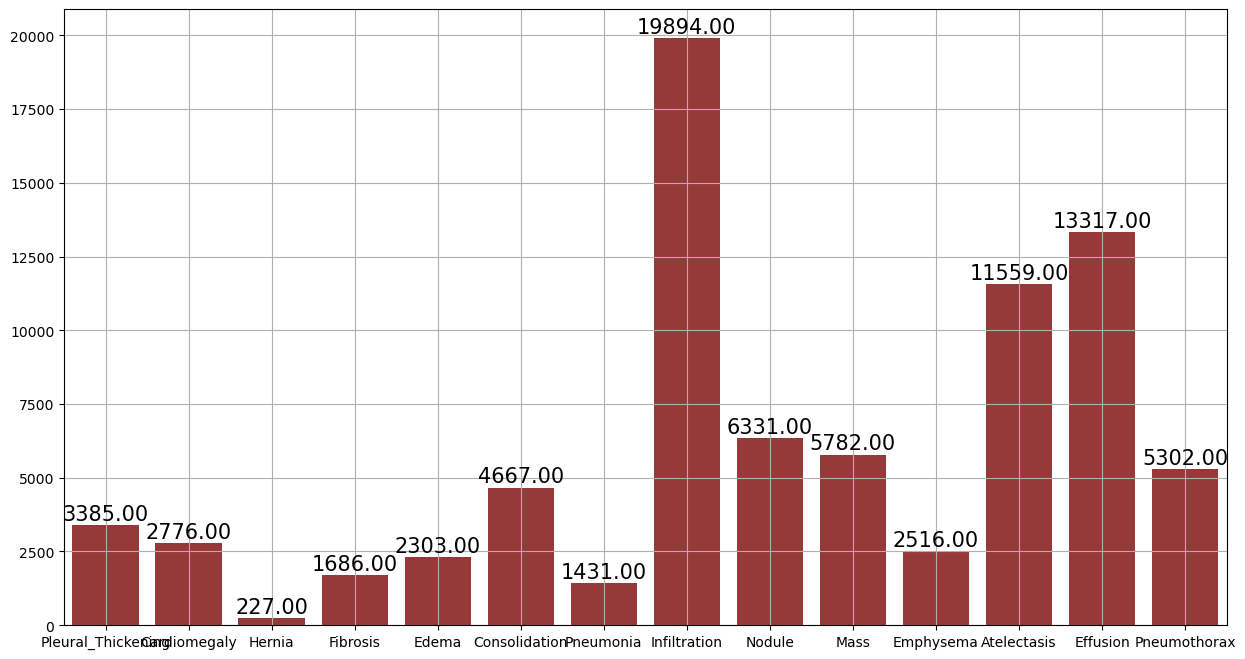

In [142]:
plt.figure(figsize=(15,8))
plots = sns.barplot(x=diseases_count.keys(), y=diseases_count.values(),color='brown')
#plt.bar(diseases_count.keys(),diseases_count.values(),color='g')
for bar in plots.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
plt.grid()
plt.show()

In [ ]:
all_xray_diseases_df.columns

Index(['ImageIndex', 'FindingLabels', 'Follow-up#', 'PatientID', 'PatientAge',
       'PatientGender', 'ViewPosition', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacing_x',
       'OriginalImagePixelSpacing_y', 'Unnamed:11', 'disease_count',
       'Pleural_Thickening', 'Cardiomegaly', 'Hernia', 'Fibrosis', 'Edema',
       'Consolidation', 'Pneumonia', 'Infiltration', 'Nodule', 'Mass',
       'Emphysema', 'Atelectasis', 'Effusion', 'Pneumothorax'],
      dtype='object')

In [137]:
all_xray_diseases_df.query("Pneumonia==1")['disease_count'].value_counts(normalize=True)*100

disease_count
2    38.015374
3    26.974144
1    22.501747
4     9.643606
5     2.375961
7     0.209644
6     0.209644
9     0.069881
Name: proportion, dtype: float64

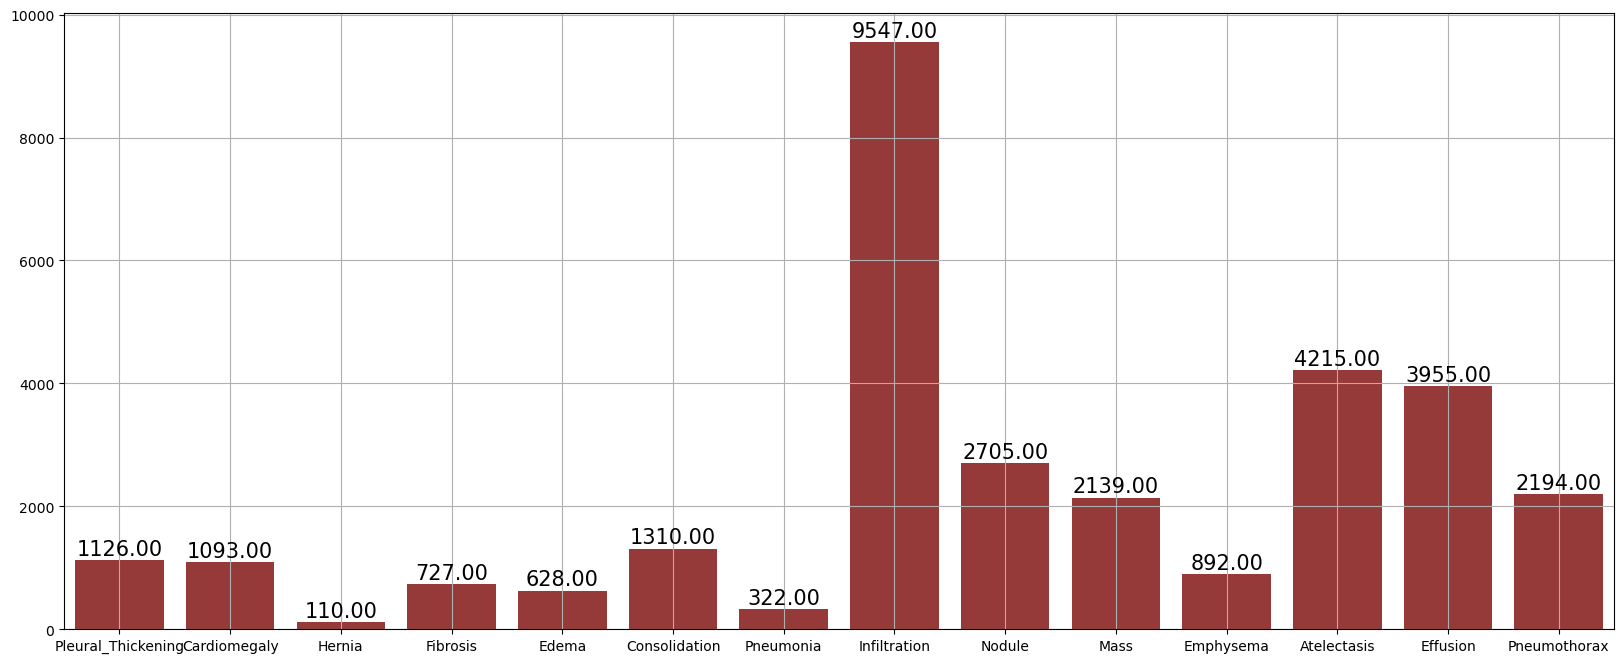

In [62]:
df_tmp=all_xray_diseases_df[all_xray_diseases_df.disease_count==1]
diseases_count={}
for label in unique_labels:
    try:
        diseases_count[label]=df_tmp[label].value_counts()[1]
    except:
        diseases_count[label]=0
        
plt.figure(figsize=(20,8))
plots = sns.barplot(x=diseases_count.keys(), y=diseases_count.values(),color='brown')
plt.grid()
# Iterating over the bars one-by-one
for bar in plots.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

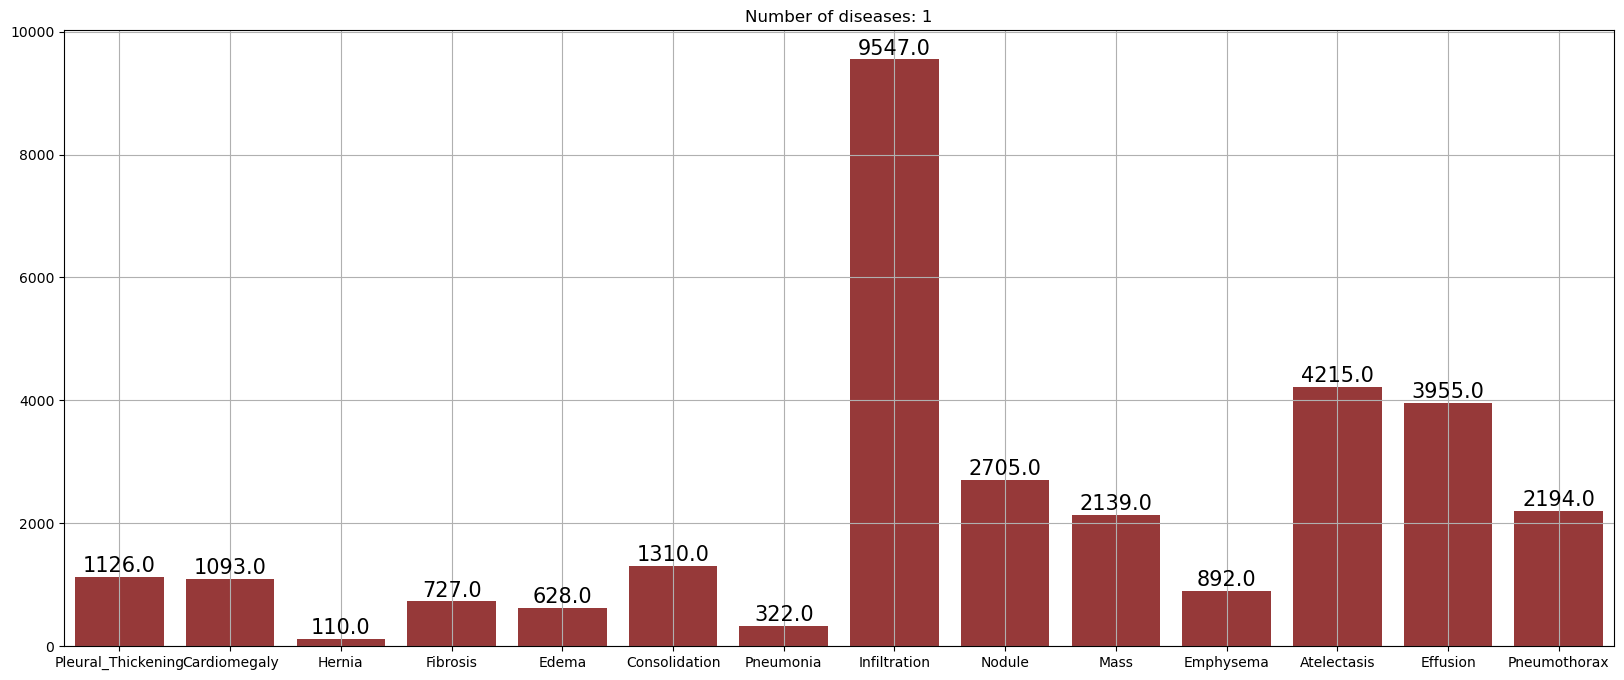

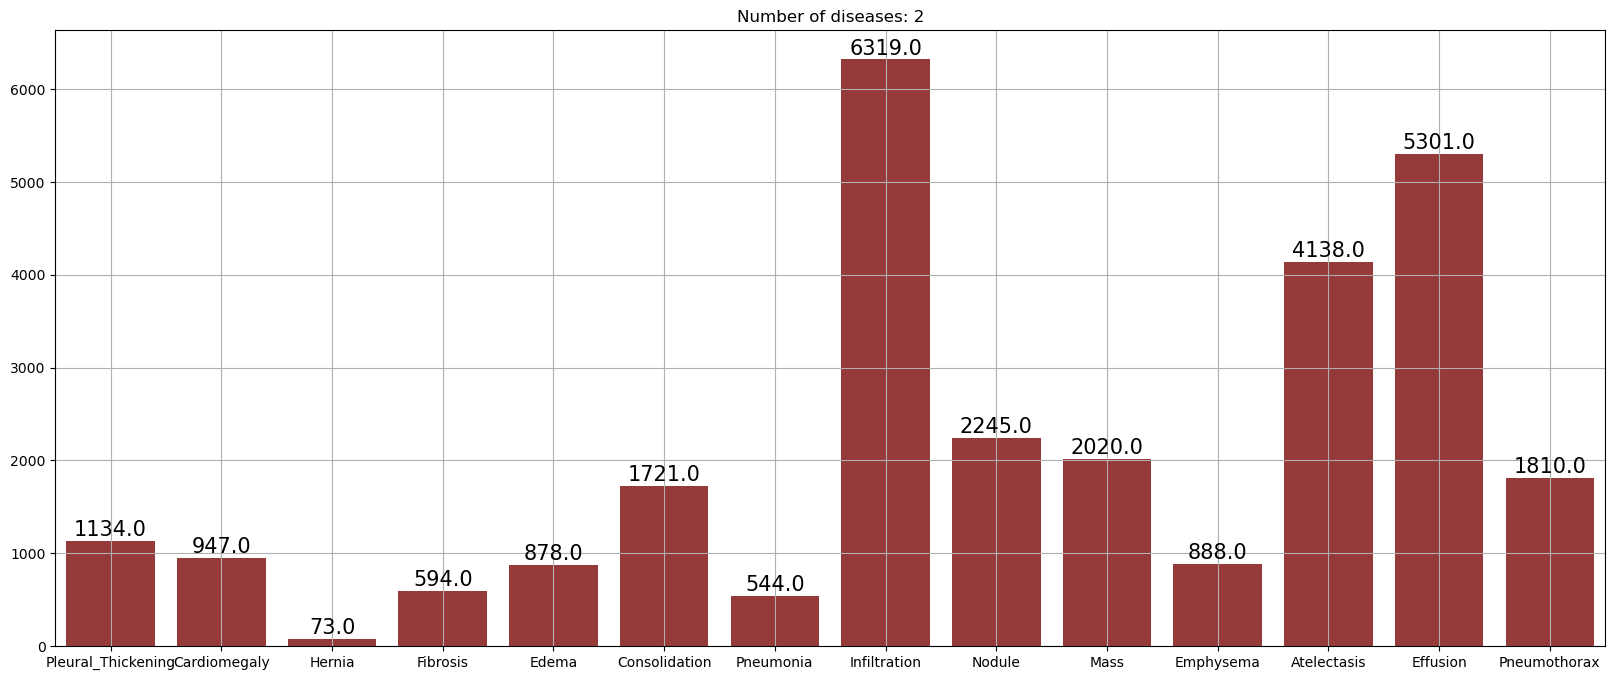

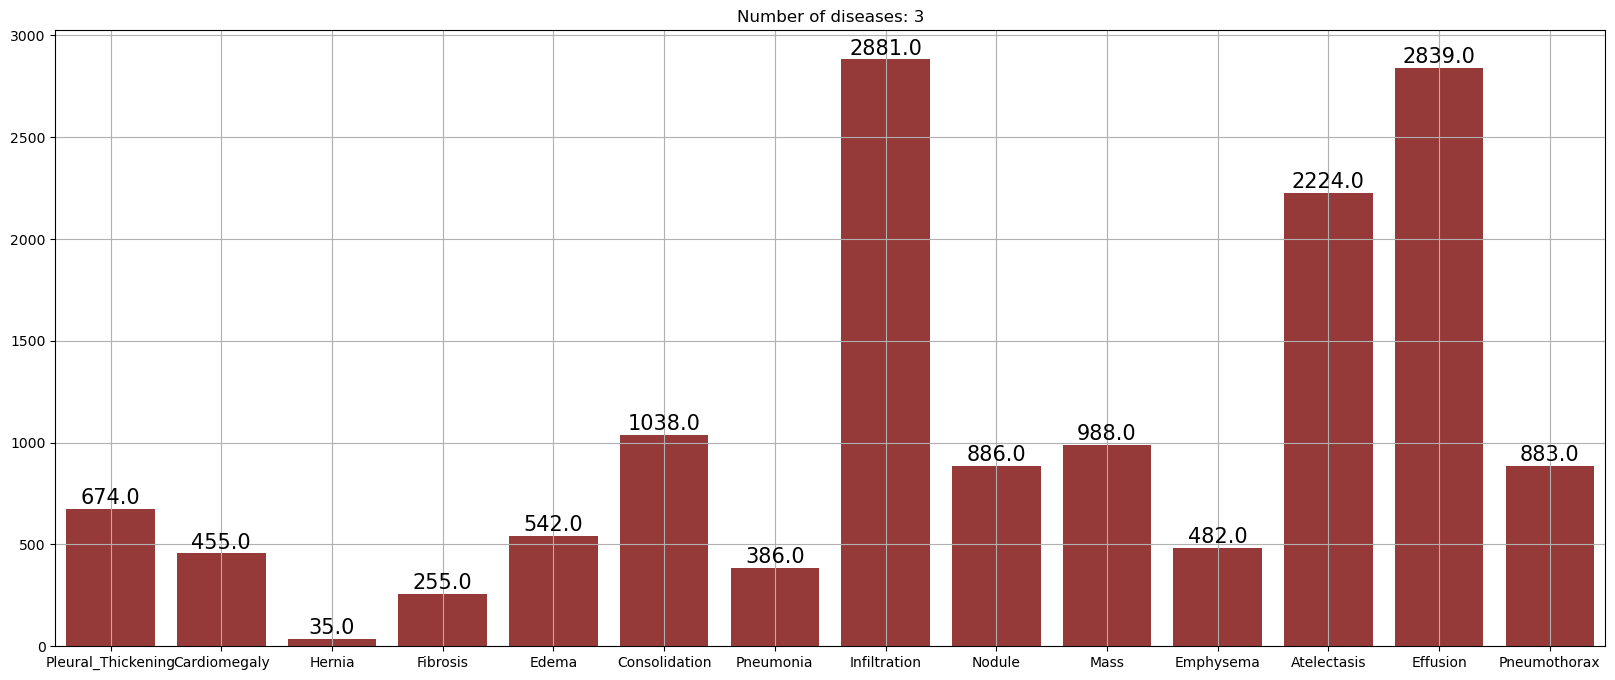

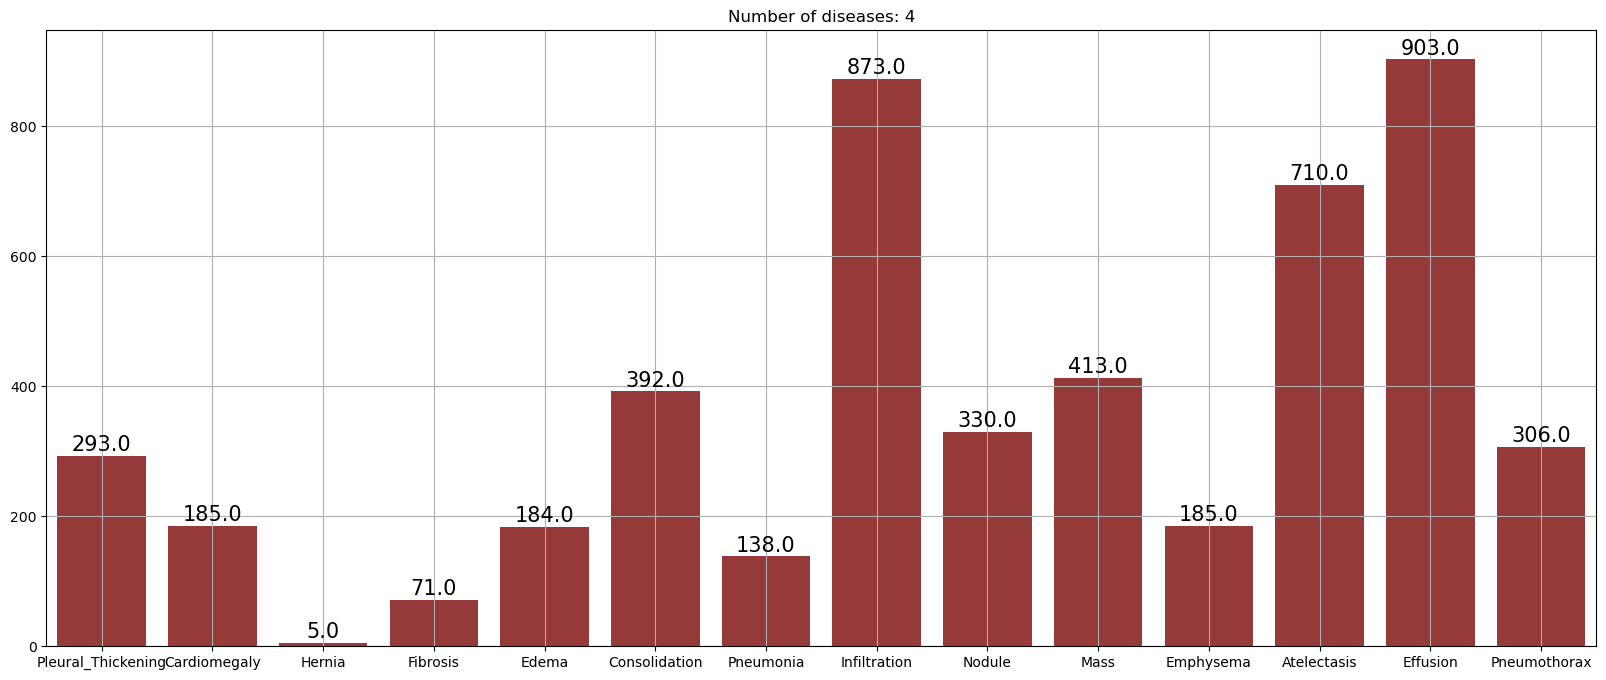

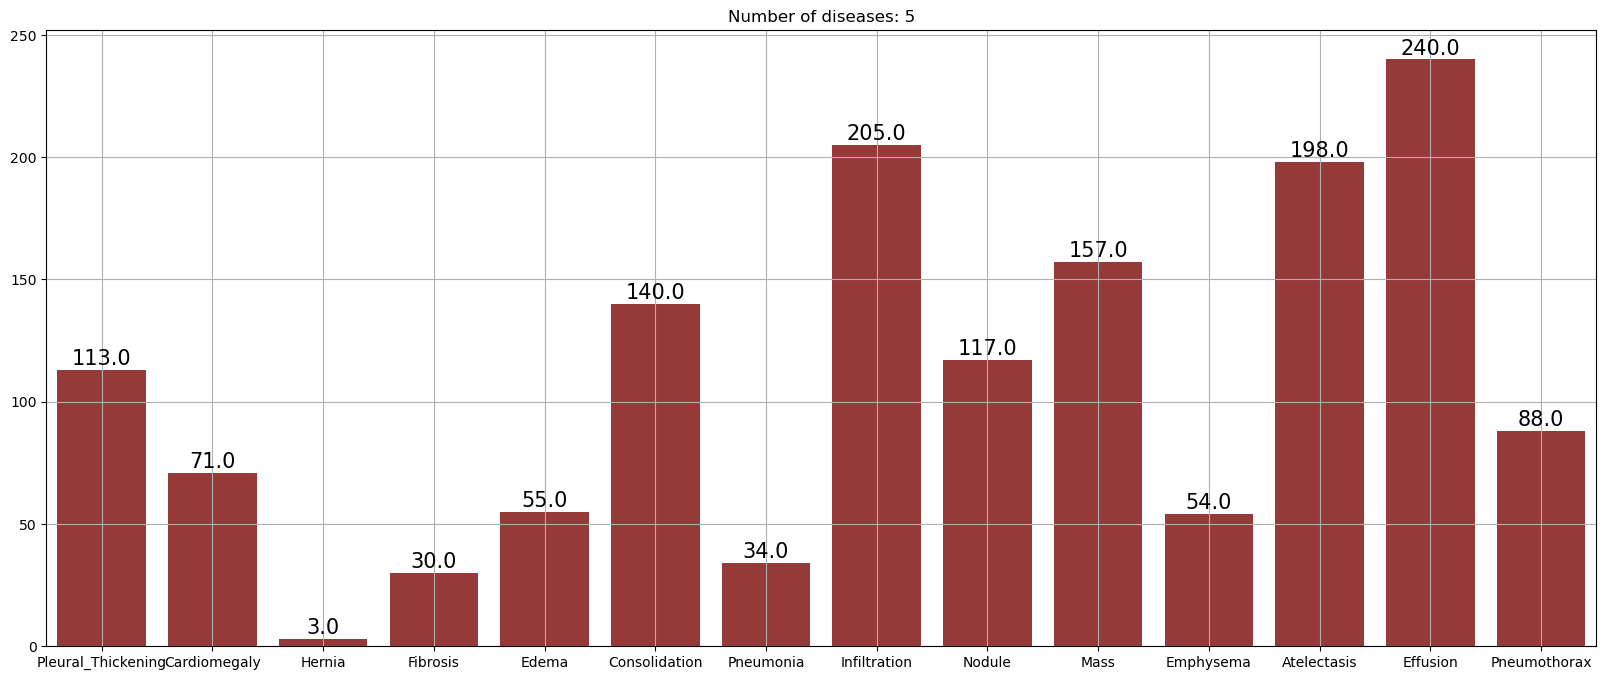

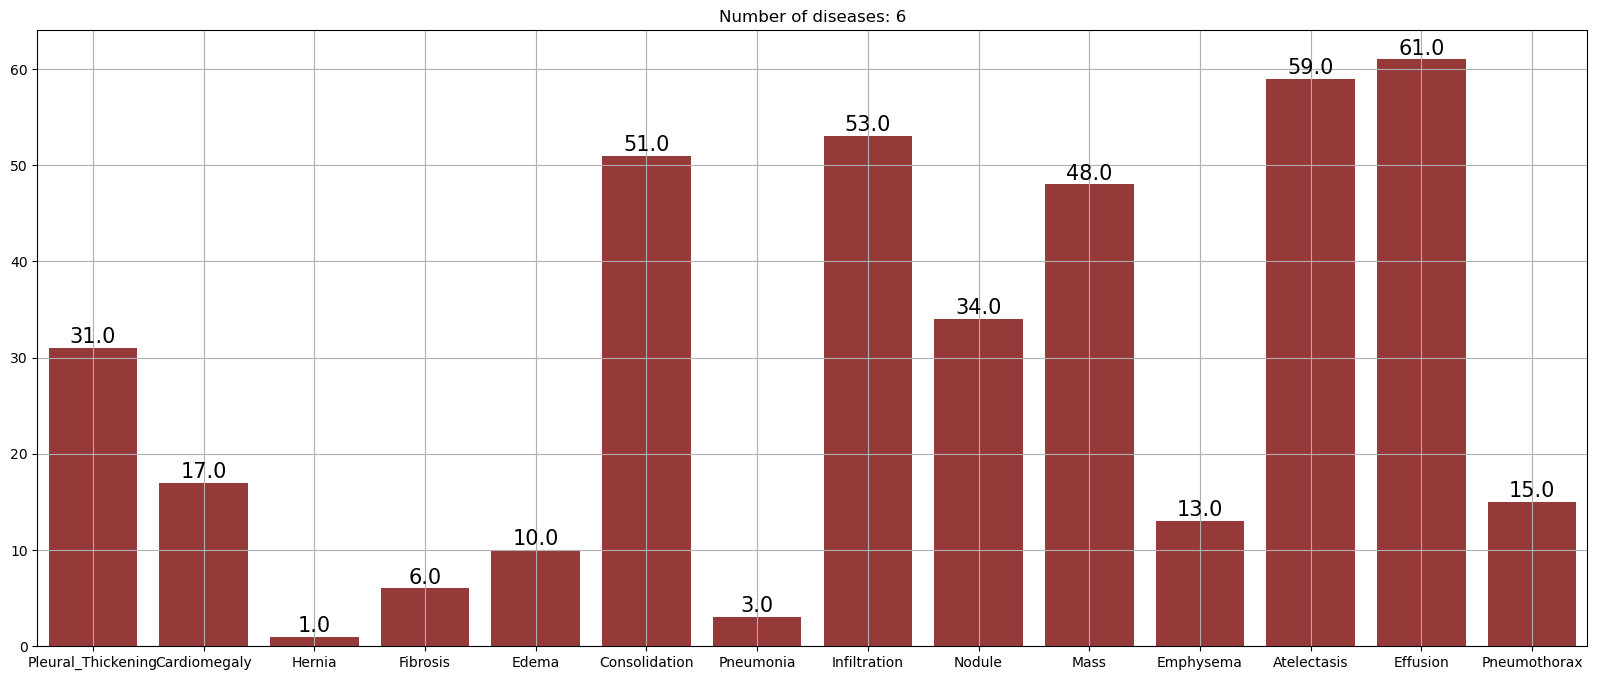

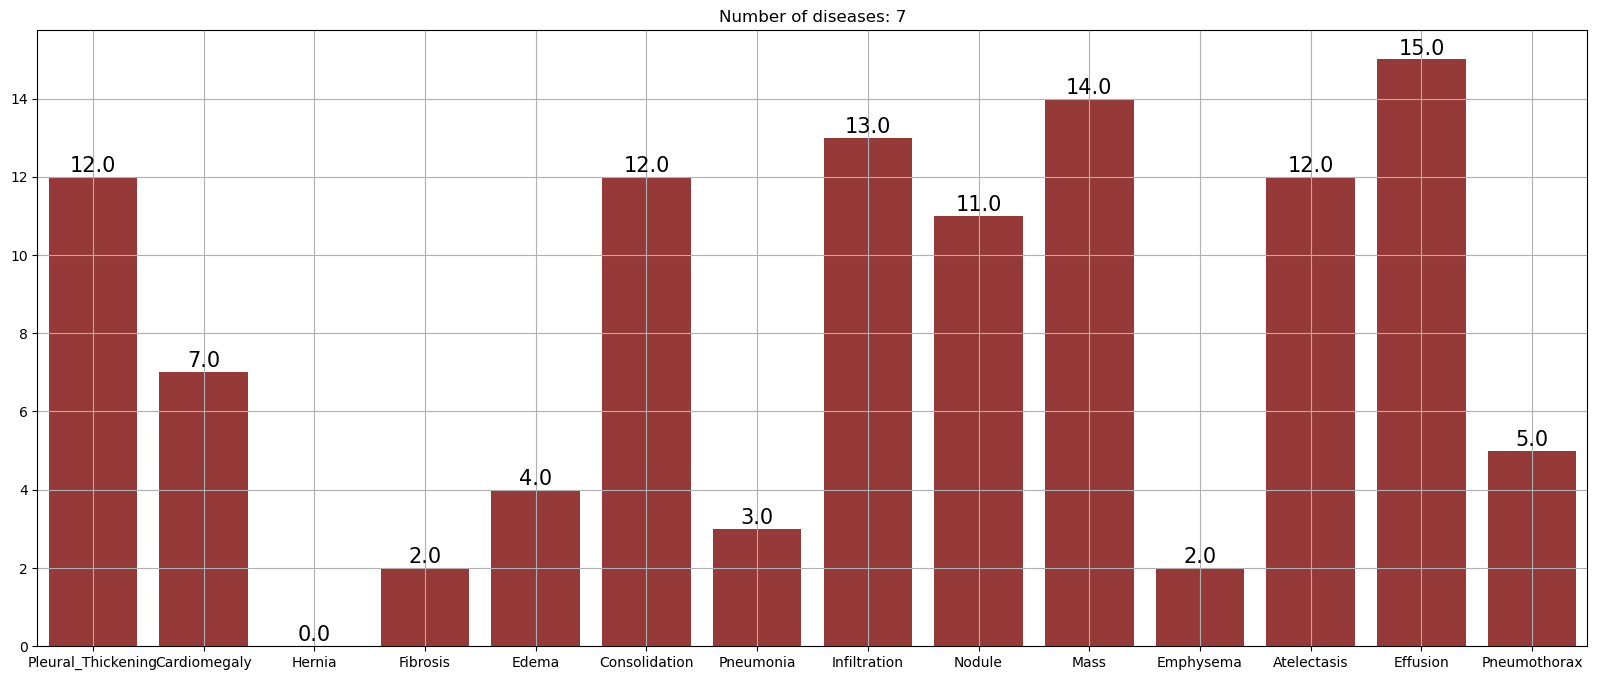

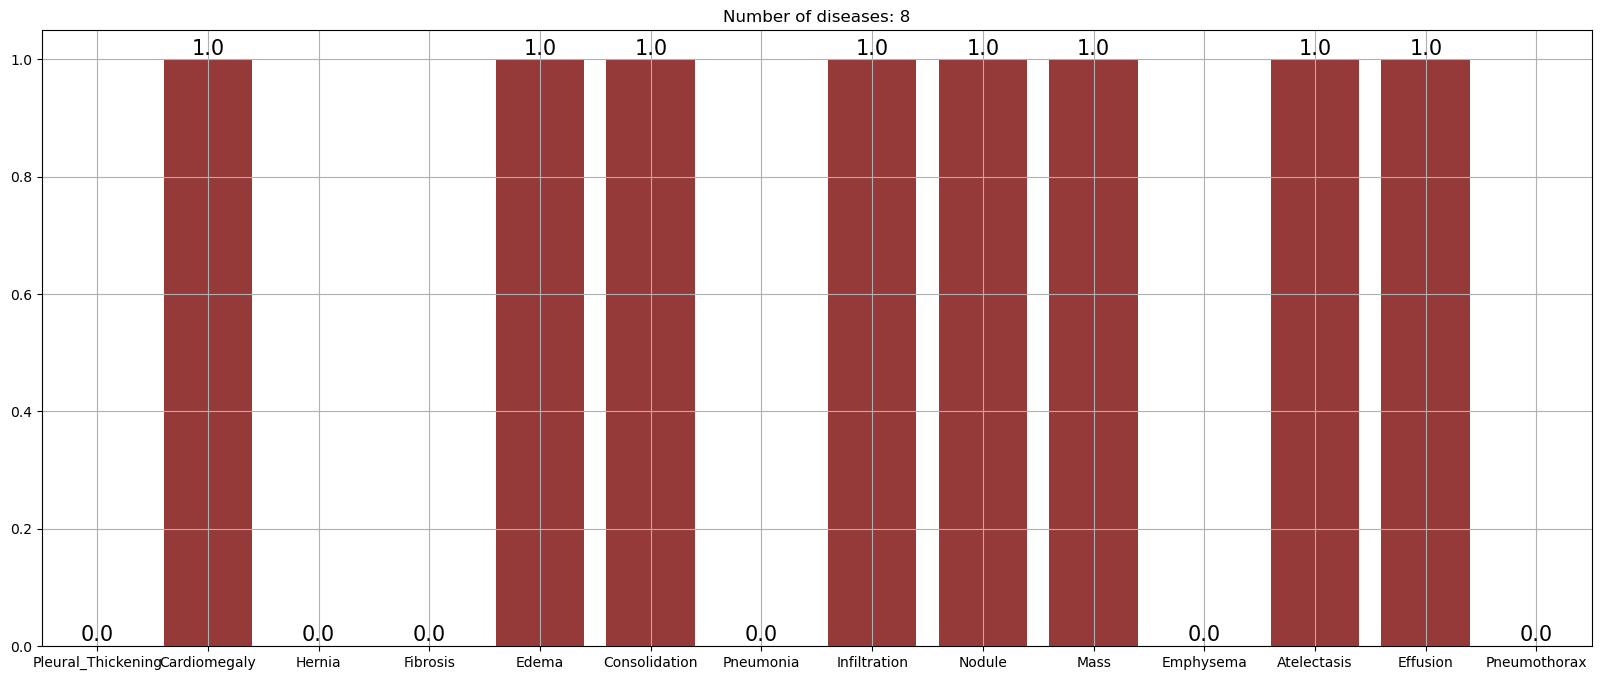

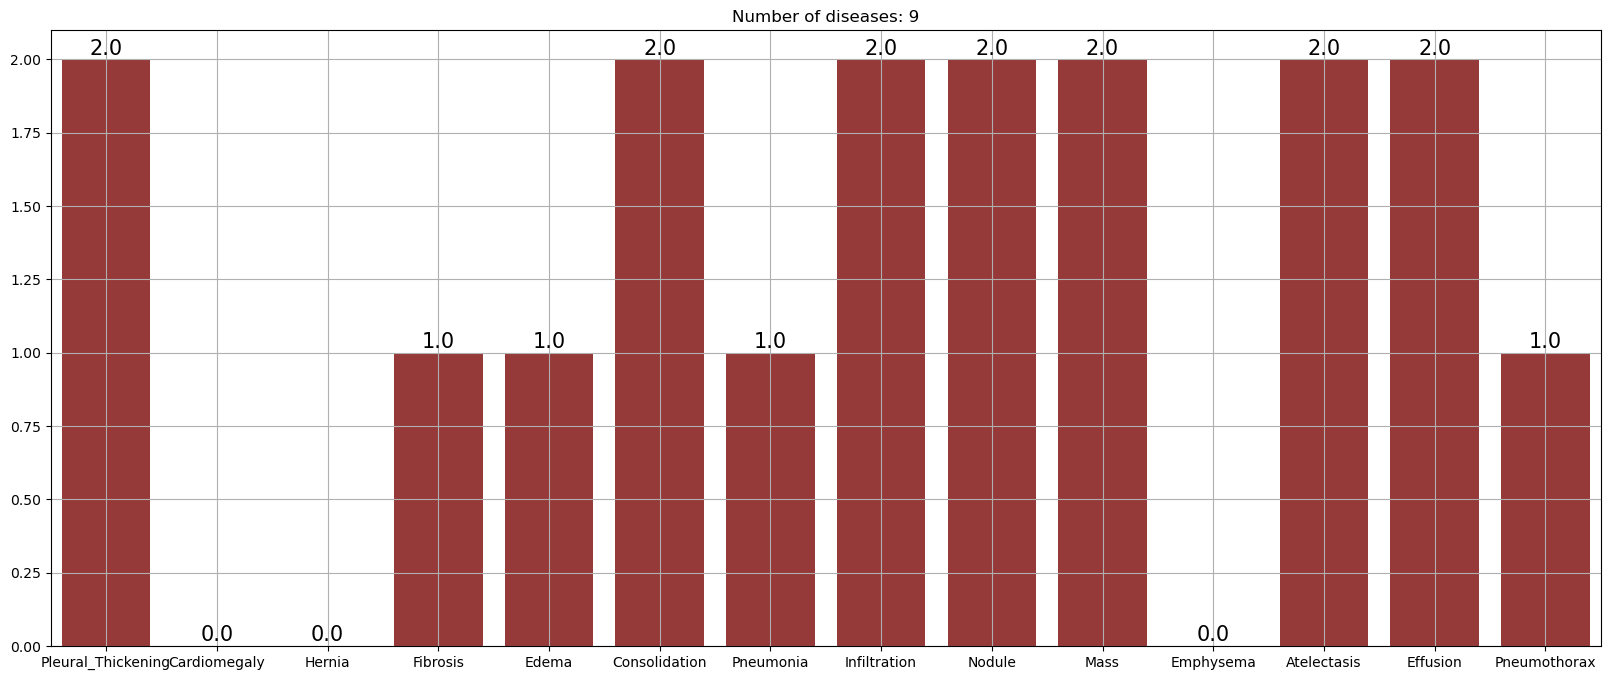

In [67]:
for i in range(1,10):
    df_tmp=all_xray_diseases_df[all_xray_diseases_df.disease_count==i]
    diseases_count={}
    for label in unique_labels:
        try:
            diseases_count[label]=df_tmp[label].value_counts()[1]
        except:
            diseases_count[label]=0
        
    plt.figure(figsize=(20,8))
    plots = sns.barplot(x=diseases_count.keys(), y=diseases_count.values(),color='brown')
    
    # Iterating over the bars one-by-one
    for bar in plots.patches:

      # Using Matplotlib's annotate function and
      # passing the coordinates where the annotation shall be done
      # x-coordinate: bar.get_x() + bar.get_width() / 2
      # y-coordinate: bar.get_height()
      # free space to be left to make graph pleasing: (0, 8)
      # ha and va stand for the horizontal and vertical alignment
        plots.annotate(bar.get_height(), 
                       (bar.get_x() + bar.get_width() / 2, 
                        bar.get_height()), ha='center', va='center',
                       size=15, xytext=(0, 8),
                       textcoords='offset points')
    plt.title(f'Number of diseases: {i}')
    plt.grid()

In [51]:
all_xray_diseases_df.query("disease_count==1 and Pneumonia==1").shape

(322, 36)

In [47]:
df_plus_pneumonia=all_xray_diseases_df.query("disease_count>1 and Pneumonia==1")
print(df_plus_pneumonia.shape)
df_plus_pneumonia.disease_count.value_counts()

(1109, 36)


disease_count
2    544
3    386
4    138
5     34
7      3
6      3
9      1
Name: count, dtype: int64

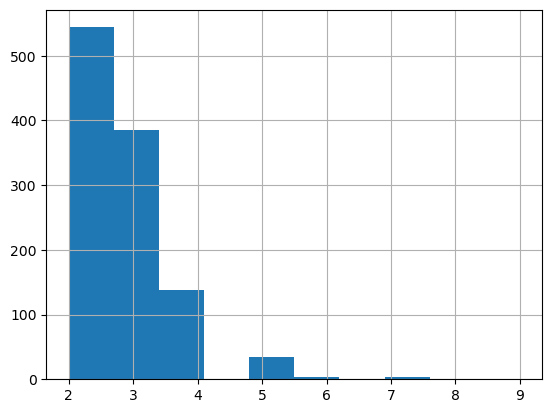

In [138]:
plt.hist(df_plus_pneumonia.disease_count);
plt.grid()

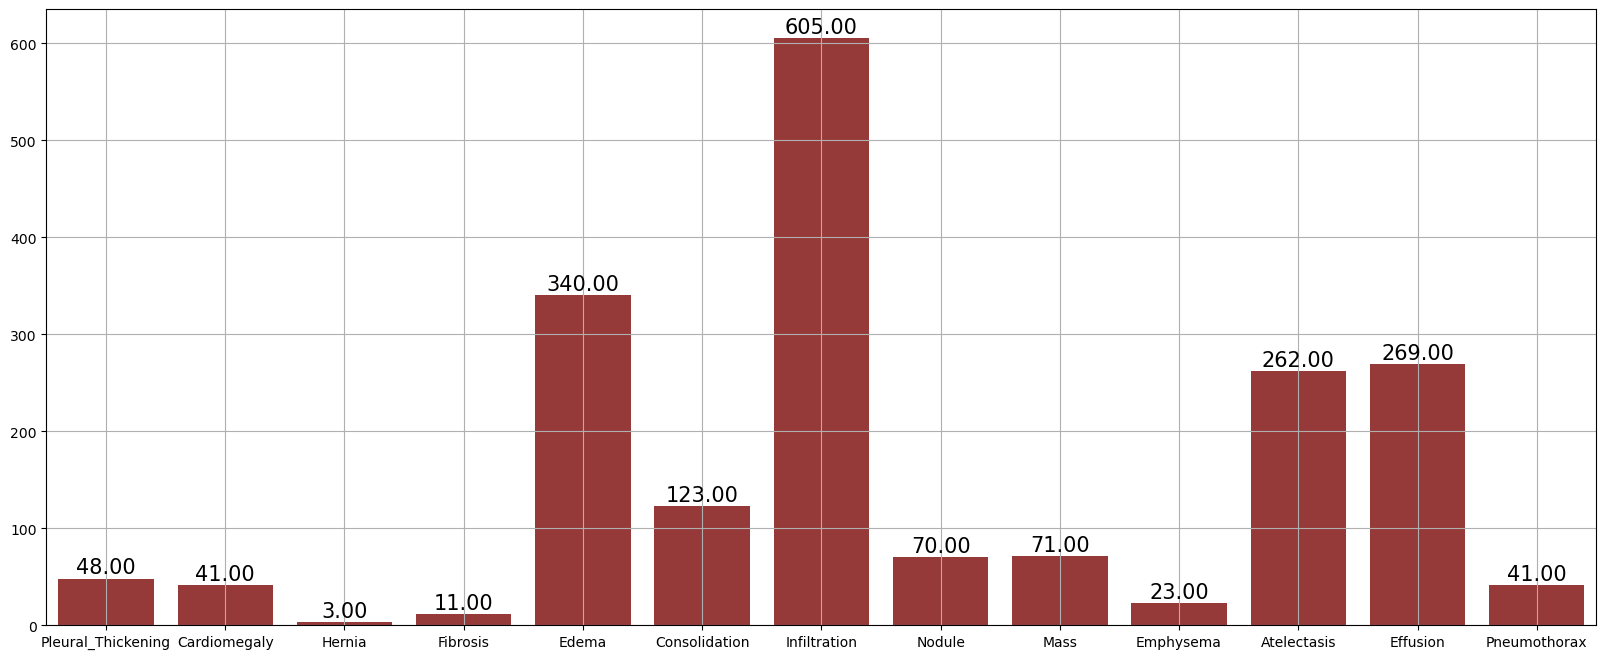

In [144]:
other_disease_counts={}
for label in unique_labels:
    if label !='Pneumonia':
        other_disease_counts[label]=df_plus_pneumonia[label].value_counts()[1]
#print(other_disease_counts)

# Plot stats
plt.figure(figsize=(20,8))
#plt.bar(other_disease_counts.keys(),other_disease_counts.values(),color='g')
plots = sns.barplot(x=other_disease_counts.keys(), y=other_disease_counts.values(),color='brown')
#plt.bar(diseases_count.keys(),diseases_count.values(),color='g')
for bar in plots.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format(bar.get_height(), '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')
plt.grid()

(544, 27)


<BarContainer object of 13 artists>

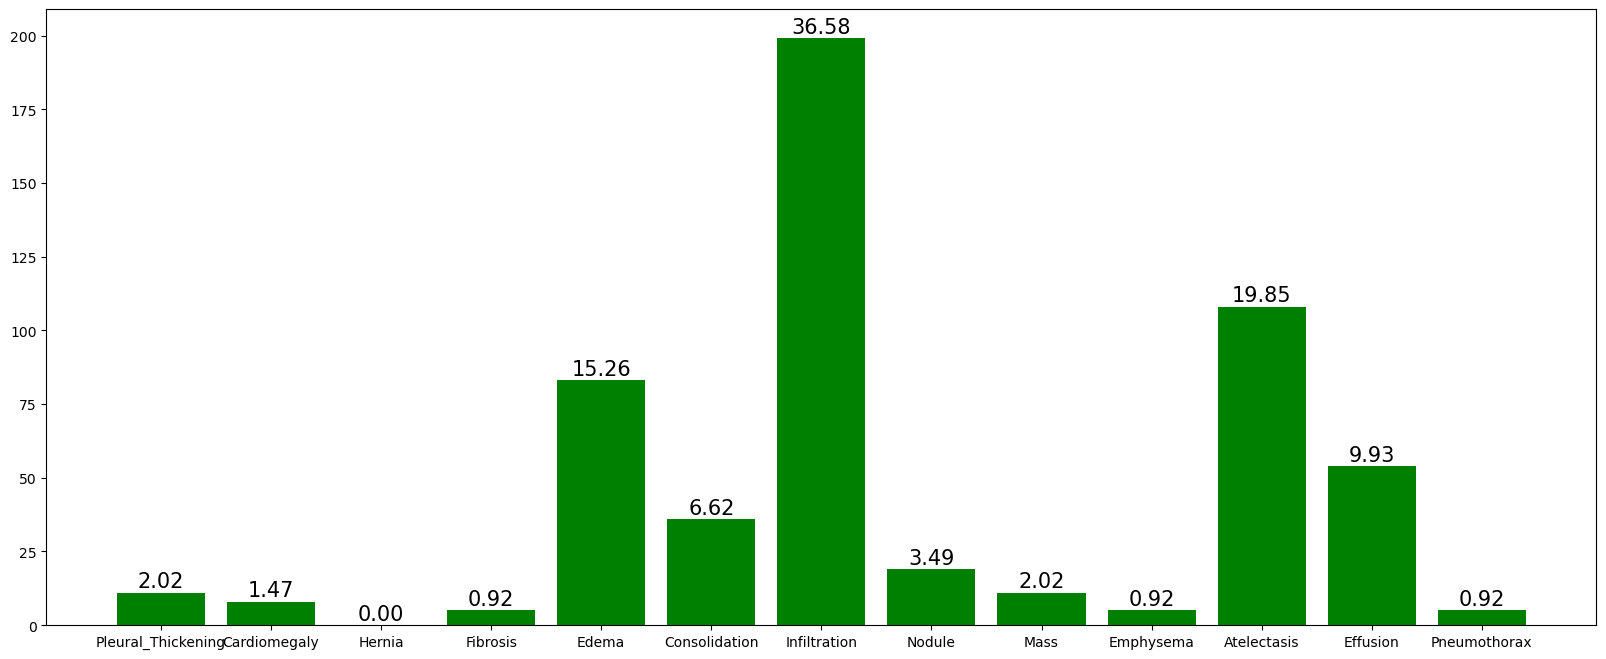

In [149]:
df_pneumonia_duo=all_xray_diseases_df.query("disease_count==2 and Pneumonia==1")
print(df_pneumonia_duo.shape)
other_disease_counts={}
for label in unique_labels:
    if label !='Pneumonia':
        try:
            other_disease_counts[label]=df_pneumonia_duo[label].value_counts()[1]
        except:
            other_disease_counts[label]=0
#print(other_disease_counts)

# Plot stats
plt.figure(figsize=(20,8))
plots = sns.barplot(x=other_disease_counts.keys(), y=other_disease_counts.values(),color='brown')
#plt.bar(diseases_count.keys(),diseases_count.values(),color='g')
for bar in plots.patches:
   
  # Using Matplotlib's annotate function and
  # passing the coordinates where the annotation shall be done
  # x-coordinate: bar.get_x() + bar.get_width() / 2
  # y-coordinate: bar.get_height()
  # free space to be left to make graph pleasing: (0, 8)
  # ha and va stand for the horizontal and vertical alignment
    plots.annotate(format((bar.get_height()/df_pneumonia_duo.shape[0])*100, '.2f'), 
                   (bar.get_x() + bar.get_width() / 2, 
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.bar(other_disease_counts.keys(),other_disease_counts.values(),color='g')

In [153]:
all_xray_df.shape[0]*.012

1345.44

### PatientID

In [182]:
all_xray_diseases_df.PatientID.nunique()

30805

In [196]:
(all_xray_diseases_df.PatientID.nunique()/all_xray_diseases_df.shape[0])*100

27.475026757046024

In [199]:
sum(all_xray_diseases_df.PatientID.value_counts()>1),sum(all_xray_diseases_df.PatientID.value_counts()==1)

(13302, 17503)

We have total of 30805 number of unique customers in the dataset, that's 27.5% of the data. Of this, we have 17503 customers who came once while 13302 who have followed up.

Questions:
- How many of the unique customers, never had pneumonia?
- How many unique customers, had multiple instances of pneumonia reported?

Answer(as found in the EDA below): 
There are a total of 1431 Pneumonia cases, of which 79 patients have one record entry in the dataset, while 929 patients have had follow ups. Of these 929 pnemonia patients, 706 have recorded pneumonia just once while 223 cases have had Pneumonia detected on multiple visits.

Unique customers that have had pneumonia = 929+79=1007
Unique customers that have had multiple instance of pneumonia reported = 223 (These cases are strong predictors of pneumonia)

Similarly, the following are also strong cases for Pneumonia detection:
- 27 of the 79 Pneumonia patients who have one recorded entry in the dataset, have only reported one disease. 
- 295 of the 1352 multiple reported pneumonia cases had one disease.

In [227]:
patient_vals=all_xray_diseases_df.PatientID.value_counts()
patient_vals

PatientID
10007    184
13670    173
15530    158
12834    157
13993    143
        ... 
13617      1
13610      1
13609      1
13607      1
30805      1
Name: count, Length: 30805, dtype: int64

In [239]:
patient_vals[patient_vals>1].index

Index([10007, 13670, 15530, 12834, 13993,  1836, 19124, 20213, 17138, 11237,
       ...
       10148,  9316, 30070, 25619, 25351, 25350,  9408, 25697,  1462, 26037],
      dtype='int64', name='PatientID', length=13302)

In [231]:
all_xray_diseases_df.PatientID.isin(patient_vals==1)

0          True
1          True
2          True
3         False
4         False
          ...  
112115    False
112116    False
112117    False
112118    False
112119    False
Name: PatientID, Length: 112120, dtype: bool

In [243]:
repeat_customers_df=all_xray_diseases_df[all_xray_diseases_df.PatientID.isin(patient_vals[patient_vals>1].index)]
print(repeat_customers_df.shape)
repeat_customers_df.head()

(94617, 28)


,ImageIndex,FindingLabels,Follow-up#,PatientID,PatientAge,PatientGender,ViewPosition,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Consolidation,Pneumonia,Infiltration,Nodule,Mass,Emphysema,Atelectasis,Effusion,Pneumothorax,AgeBracket
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,"(50, 60]"
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,0,1,0,0,0,"(50, 60]"
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,1,0,"(50, 60]"
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,0,0,0,0,0,0,0,"(80, 100]"
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,"(70, 80]"


In [244]:
one_time_customers_df=all_xray_diseases_df[all_xray_diseases_df.PatientID.isin(patient_vals[patient_vals==1].index)]
print(one_time_customers_df.shape)
one_time_customers_df.head()

(17503, 28)


,ImageIndex,FindingLabels,Follow-up#,PatientID,PatientAge,PatientGender,ViewPosition,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Consolidation,Pneumonia,Infiltration,Nodule,Mass,Emphysema,Atelectasis,Effusion,Pneumothorax,AgeBracket
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,"(80, 100]"
12,00000004_000.png,Mass|Nodule,0,4,82,M,AP,2500,2048,0.168,...,0,0,0,1,1,0,0,0,0,"(80, 100]"
21,00000006_000.png,No Finding,0,6,81,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,"(80, 100]"
22,00000007_000.png,No Finding,0,7,82,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,"(80, 100]"
26,00000009_000.png,Emphysema,0,9,73,M,PA,2992,2991,0.143,...,0,0,0,0,0,1,0,0,0,"(70, 80]"


In [246]:
one_time_customers_df.Pneumonia.value_counts()

Pneumonia
0    17424
1       79
Name: count, dtype: int64

In [249]:
repeat_customers_df.Pneumonia.value_counts()

Pneumonia
0    93265
1     1352
Name: count, dtype: int64

In [274]:
pneumonia_grps=all_xray_diseases_df.groupby('PatientID')['Pneumonia'].value_counts()
pneumonia_grps

PatientID  Pneumonia
1          0            3
2          0            1
3          0            8
4          0            1
5          0            8
                       ..
30801      0            1
30802      0            1
30803      0            1
30804      0            1
30805      0            1
Name: count, Length: 31733, dtype: int64

In [288]:
31733-30805+1

929

In [278]:
928+79

1007

In [283]:
s_tmp=repeat_customers_df.groupby('PatientID')['Pneumonia'].sum()
s_tmp

PatientID
1        0
3        0
5        0
8        0
11       0
        ..
30773    0
30786    0
30791    0
30792    0
30801    1
Name: Pneumonia, Length: 13302, dtype: int64

In [286]:
s_tmp[s_tmp==0]

PatientID
1        0
3        0
5        0
8        0
11       0
        ..
30772    0
30773    0
30786    0
30791    0
30792    0
Name: Pneumonia, Length: 12373, dtype: int64

In [287]:
13302-12373

929

In [294]:
s_tmp[s_tmp>1]

PatientID
61       2
211      2
218      2
261      2
468      2
        ..
29431    2
29469    2
29861    2
30079    4
30519    2
Name: Pneumonia, Length: 223, dtype: int64

In [290]:
1352+79

1431

In [302]:
repeat_customers_df.query("disease_count==1 and Pneumonia==1").shape

(295, 28)

In [296]:
one_time_customers_df.query("disease_count==1 and Pneumonia==1").shape

(27, 28)

In [73]:
all_xray_df.PatientID.value_counts()[:50]

10007    184
13670    173
15530    158
12834    157
13993    143
1836     137
19124    130
20213    119
17138    117
11237    116
13111    116
21201    114
17236    111
20326    109
19176    108
14022    108
6271     108
4808     102
16587     99
18253     91
27213     90
22572     90
4858      89
10531     88
3028      87
12021     86
4893      86
11702     86
22416     84
25252     84
7034      83
4006      81
13625     81
22815     81
27415     80
12364     80
11925     79
11460     77
26451     77
18921     76
27725     76
10352     75
30079     74
19271     73
12628     73
13615     71
20408     71
8468      70
19576     70
13310     69
Name: PatientID, dtype: int64

In [199]:
all_xray_diseases_df[all_xray_diseases_df['PatientID']==10007]['FindingLabels'].value_counts()

FindingLabels
No Finding                                              45
Effusion                                                21
Effusion|Infiltration                                   13
Pleural_Thickening                                      12
Consolidation                                           11
Infiltration                                            11
Atelectasis|Consolidation                                5
Atelectasis|Consolidation|Effusion|Infiltration          5
Cardiomegaly                                             4
Infiltration|Mass                                        4
Cardiomegaly|Effusion                                    4
Effusion|Infiltration|Pleural_Thickening                 3
Edema|Pleural_Thickening                                 3
Effusion|Infiltration|Pneumothorax                       3
Effusion|Infiltration|Mass                               3
Infiltration|Pleural_Thickening                          3
Edema|Infiltration                        

In [201]:
all_xray_diseases_df[(all_xray_diseases_df['PatientID']==10007)&(all_xray_diseases_df['Pneumonia']==1)]

,ImageIndex,FindingLabels,Follow-up#,PatientID,PatientAge,PatientGender,ViewPosition,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Consolidation,Pneumonia,Infiltration,Nodule,Mass,Emphysema,Atelectasis,Effusion,Pneumothorax,AgeBracket


There are patients who visited several times though never were diagnosed with Pneumonia specifically. 



In [217]:
all_xray_diseases_df.PatientID.value_counts()

PatientID
10007    False
13670    False
15530    False
12834    False
13993    False
         ...  
13617     True
13610     True
13609     True
13607     True
30805     True
Name: count, Length: 30805, dtype: bool

In [220]:
all_xray_diseases_df.where(all_xray_diseases_df.PatientID.value_counts()==1)

,ImageIndex,FindingLabels,Follow-up#,PatientID,PatientAge,PatientGender,ViewPosition,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Consolidation,Pneumonia,Infiltration,Nodule,Mass,Emphysema,Atelectasis,Effusion,Pneumothorax,AgeBracket
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2.0,1.0,58.0,M,PA,2500.0,2048.0,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"(50.0, 60.0]"
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,00000003_000.png,Hernia,0.0,3.0,81.0,F,PA,2582.0,2991.0,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"(80.0, 100.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
112118,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Patient Age

In [155]:
all_xray_df.columns

Index(['ImageIndex', 'FindingLabels', 'Follow-up#', 'PatientID', 'PatientAge',
       'PatientGender', 'ViewPosition', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacing_x',
       'OriginalImagePixelSpacing_y', 'Unnamed:11', 'disease_count',
       'Pleural_Thickening', 'Cardiomegaly', 'Hernia', 'Fibrosis', 'Edema',
       'Consolidation', 'Pneumonia', 'Infiltration', 'Nodule', 'Mass',
       'Emphysema', 'Atelectasis', 'Effusion', 'Pneumothorax'],
      dtype='object')

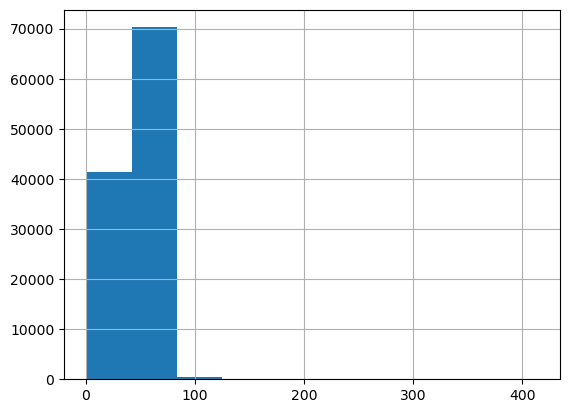

In [157]:
plt.hist(all_xray_df['PatientAge']);
plt.grid()

In [159]:
all_xray_diseases_df[all_xray_diseases_df['PatientAge']>=100]

,ImageIndex,FindingLabels,Follow-up#,PatientID,PatientAge,PatientGender,ViewPosition,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Edema,Consolidation,Pneumonia,Infiltration,Nodule,Mass,Emphysema,Atelectasis,Effusion,Pneumothorax
20852,00005567_000.png,Effusion|Pneumonia,0,5567,412,M,AP,3056,2544,0.139,...,0,0,1,0,0,0,0,0,1,0
46965,00011973_002.png,Edema,2,11973,414,M,AP,3056,2544,0.139,...,1,0,0,0,0,0,0,0,0,0
48284,00012238_010.png,No Finding,10,12238,148,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,0,0
55742,00013950_000.png,No Finding,0,13950,148,M,PA,2964,2939,0.143,...,0,0,0,0,0,0,0,0,0,0
58650,00014520_026.png,Infiltration|Mass,26,14520,150,M,PA,2992,2991,0.143,...,0,0,0,1,0,1,0,0,0,0
62929,00015558_000.png,No Finding,0,15558,149,M,PA,2992,2991,0.143,...,0,0,0,0,0,0,0,0,0,0
74884,00018366_044.png,Pneumothorax,44,18366,152,F,PA,2302,2991,0.143,...,0,0,0,0,0,0,0,0,0,1
78795,00019346_000.png,Infiltration,0,19346,151,F,PA,2678,2774,0.143,...,0,0,0,1,0,0,0,0,0,0
84810,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,0,0,0
85404,00021047_002.png,Mass|Pleural_Thickening,2,21047,412,M,AP,3056,2544,0.139,...,0,0,0,0,0,1,0,0,0,0


In [216]:
all_xray_diseases_df.loc[all_xray_diseases_df['PatientAge']>=100,'disease_count'].value_counts()

0    8
2    4
1    4
Name: disease_count, dtype: int64

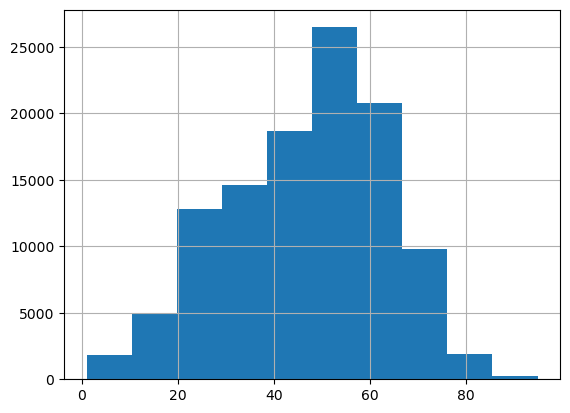

In [158]:
plt.hist(all_xray_diseases_df[all_xray_diseases_df['PatientAge']<=100]['PatientAge'])
plt.grid()

In [160]:
bins=[0,10,20,30,40,50,60,70,80,100,500]
# help(pd.cut)
all_xray_diseases_df['AgeBracket']=pd.cut(all_xray_diseases_df['PatientAge'],bins)
all_xray_diseases_df['AgeBracket'].value_counts(normalize=True)*100

AgeBracket
(50, 60]      24.438994
(40, 50]      19.711916
(60, 70]      15.965929
(30, 40]      14.896539
(20, 30]      11.988049
(10, 20]       5.359436
(70, 80]       5.231002
(0, 10]        1.608098
(80, 100]      0.785765
(100, 500]     0.014270
Name: proportion, dtype: float64

In [161]:
all_xray_diseases_df.groupby('AgeBracket')['Pneumonia'].value_counts(normalize=True)*100

AgeBracket  Pneumonia
(0, 10]     0            97.726012
            1             2.273988
(10, 20]    0            98.419038
            1             1.580962
(20, 30]    0            98.512015
            1             1.487985
(30, 40]    0            98.521135
            1             1.478865
(40, 50]    0            98.868829
            1             1.131171
(50, 60]    0            98.908799
            1             1.091201
(60, 70]    0            98.726328
            1             1.273672
(70, 80]    0            98.976982
            1             1.023018
(80, 100]   0            98.864926
            1             1.135074
(100, 500]  0            93.750000
            1             6.250000
Name: proportion, dtype: float64

### Patient Gender 

M    0.56493
F    0.43507
Name: Patient Gender, dtype: float64


<AxesSubplot:xlabel='Patient Gender', ylabel='count'>

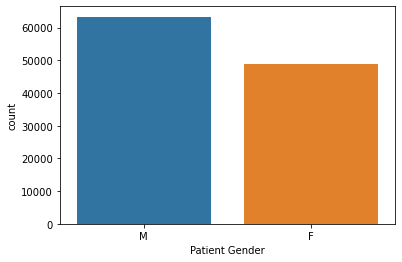

In [22]:
print(all_xray_df['Patient Gender'].value_counts(normalize=True))
sns.countplot(data=all_xray_df,x='Patient Gender')

In [162]:
all_xray_diseases_df.groupby('PatientGender')['Pneumonia'].value_counts(normalize=True)*100

PatientGender  Pneumonia
F              0            98.784338
               1             1.215662
M              0            98.676981
               1             1.323019
Name: proportion, dtype: float64

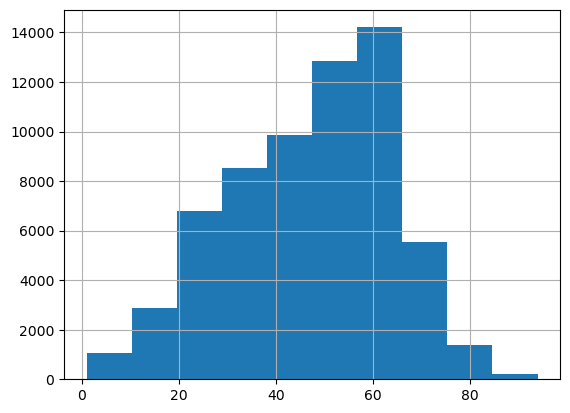

In [168]:
plt.hist(all_xray_diseases_df.query('PatientAge <=100 & PatientGender=="M"')['PatientAge'])
plt.grid()

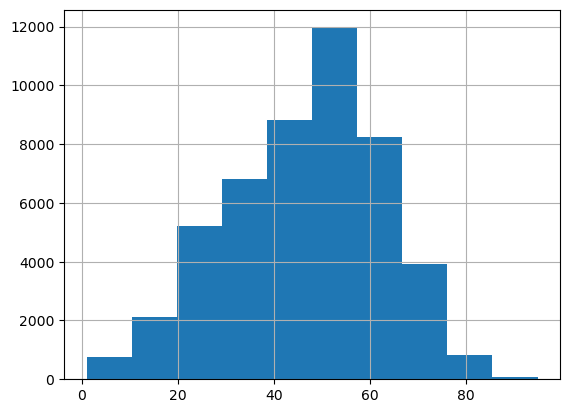

In [169]:
plt.hist(all_xray_diseases_df.query('PatientAge <=100 & PatientGender=="F"')['PatientAge'])
plt.grid()

### View Position
Position of patient Lying on the right (PA) or left (AP) side. The knees and hips may be flexed for comfort. The patient's arms should be extended over the head to prevent overlapping the sternum. The patient should be asked to breathe OUT and hold while the exposure is taken.

PA    0.600339
AP    0.399661
Name: View Position, dtype: float64


<AxesSubplot:xlabel='View Position', ylabel='count'>

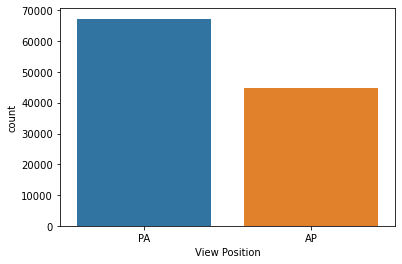

In [23]:
print(all_xray_df['View Position'].value_counts(normalize=True))
sns.countplot(data=all_xray_df,x='View Position')

In [163]:
all_xray_diseases_df.groupby('ViewPosition')['Pneumonia'].value_counts(normalize=True)*100

ViewPosition  Pneumonia
AP            0            98.212453
              1             1.787547
PA            0            99.064032
              1             0.935968
Name: proportion, dtype: float64

In [165]:
all_xray_diseases_df.groupby('PatientGender')['ViewPosition'].value_counts(normalize=True)*100

PatientGender  ViewPosition
F              PA              61.842968
               AP              38.157032
M              PA              58.640669
               AP              41.359331
Name: proportion, dtype: float64

In [175]:
all_xray_df

Index(['ImageIndex', 'FindingLabels', 'Follow-up#', 'PatientID', 'PatientAge',
       'PatientGender', 'ViewPosition', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacing_x',
       'OriginalImagePixelSpacing_y', 'Unnamed:11', 'disease_count',
       'Pleural_Thickening', 'Cardiomegaly', 'Hernia', 'Fibrosis', 'Edema',
       'Consolidation', 'Pneumonia', 'Infiltration', 'Nodule', 'Mass',
       'Emphysema', 'Atelectasis', 'Effusion', 'Pneumothorax', 'diseased'],
      dtype='object')

#### Original Image Height and Width

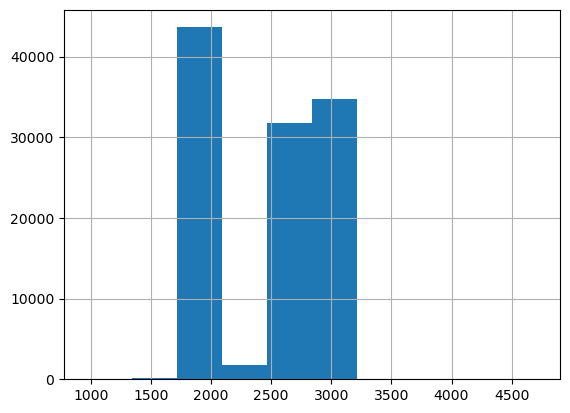

In [176]:
plt.hist(all_xray_diseases_df['OriginalImageHeight'])
plt.grid()

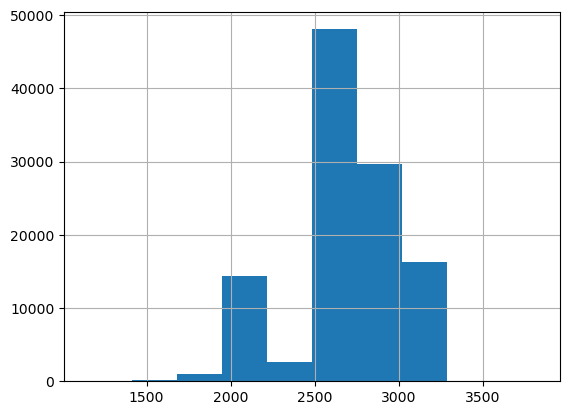

In [177]:
plt.hist(all_xray_diseases_df['OriginalImageWidth'])
plt.grid()

In [179]:
all_xray_diseases_df[all_xray_diseases_df['OriginalImageHeight']>3500]

,ImageIndex,FindingLabels,Follow-up#,PatientID,PatientAge,PatientGender,ViewPosition,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Consolidation,Pneumonia,Infiltration,Nodule,Mass,Emphysema,Atelectasis,Effusion,Pneumothorax,AgeBracket
106673,00028774_025.png,Effusion,25,28774,68,F,AP,3827,3567,0.139,...,0,0,0,0,0,0,0,1,0,"(60, 70]"
108667,00029476_000.png,No Finding,0,29476,66,M,AP,2556,4715,0.139,...,0,0,0,0,0,0,0,0,0,"(60, 70]"


In [181]:
all_xray_diseases_df[all_xray_diseases_df['OriginalImageHeight']<1500]

,ImageIndex,FindingLabels,Follow-up#,PatientID,PatientAge,PatientGender,ViewPosition,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Consolidation,Pneumonia,Infiltration,Nodule,Mass,Emphysema,Atelectasis,Effusion,Pneumothorax,AgeBracket
22136,00005864_004.png,No Finding,4,5864,6,F,PA,1894,1365,0.143000,...,0,0,0,0,0,0,0,0,0,"(0, 10]"
30265,00007889_000.png,Atelectasis|Infiltration,0,7889,5,F,PA,2160,1310,0.143000,...,0,0,1,0,0,0,1,0,0,"(0, 10]"
47462,00012051_003.png,No Finding,3,12051,9,F,PA,1670,1464,0.194311,...,0,0,0,0,0,0,0,0,0,"(0, 10]"
53031,00013378_000.png,Atelectasis,0,13378,11,M,PA,1378,1245,0.143000,...,0,0,0,0,0,0,1,0,0,"(10, 20]"
69369,00017121_001.png,No Finding,1,17121,18,M,PA,1334,1356,0.143000,...,0,0,0,0,0,0,0,0,0,"(10, 20]"
75173,00018445_000.png,No Finding,0,18445,4,F,PA,1936,1415,0.143000,...,0,0,0,0,0,0,0,0,0,"(0, 10]"
75174,00018445_001.png,No Finding,1,18445,6,F,PA,1329,1477,0.194311,...,0,0,0,0,0,0,0,0,0,"(0, 10]"
77180,00018962_000.png,No Finding,0,18962,18,F,PA,2274,1489,0.143000,...,0,0,0,0,0,0,0,0,0,"(10, 20]"
77503,00019045_003.png,Infiltration,3,19045,13,F,PA,1562,1001,0.143000,...,0,0,1,0,0,0,0,0,0,"(10, 20]"
79441,00019515_000.png,No Finding,0,19515,7,M,AP,1940,1416,0.139000,...,0,0,0,0,0,0,0,0,0,"(0, 10]"


In [180]:
all_xray_diseases_df[all_xray_diseases_df['OriginalImageWidth']>3500]

,ImageIndex,FindingLabels,Follow-up#,PatientID,PatientAge,PatientGender,ViewPosition,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,...,Consolidation,Pneumonia,Infiltration,Nodule,Mass,Emphysema,Atelectasis,Effusion,Pneumothorax,AgeBracket
106673,00028774_025.png,Effusion,25,28774,68,F,AP,3827,3567,0.139,...,0,0,0,0,0,0,0,1,0,"(60, 70]"
109176,00029670_007.png,Atelectasis|Consolidation|Edema|Effusion,7,29670,76,F,AP,3550,3166,0.139,...,1,0,0,0,0,0,1,1,0,"(70, 80]"


#### Original Image Spacing

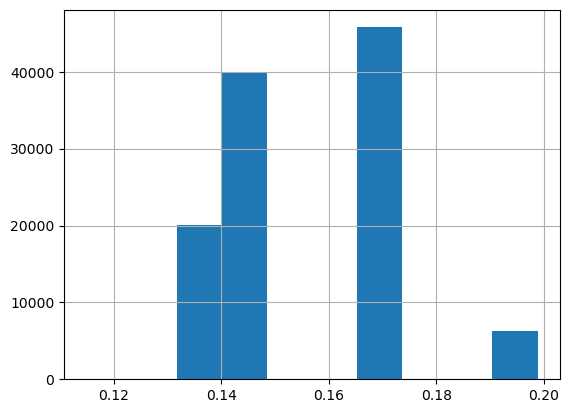

In [233]:
plt.hist(all_xray_diseases_df['OriginalImagePixelSpacing_x'])
plt.grid()

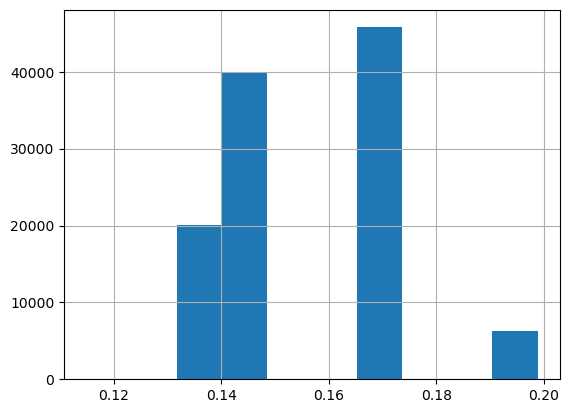

In [234]:
plt.hist(all_xray_diseases_df['OriginalImagePixelSpacing_y'])
plt.grid()

## EDA Notes
- Remove records with age above 100
- There are 30805 different patients in the dataset, of which 13302 have followed up in the past